In [79]:
import math
import logging
from typing import Union
from pathlib import Path
from urllib.parse import urlparse, parse_qsl, urlsplit

import pandas as pd
import seaborn as sb
import json
import requests
import fhirclient

from IPython.display import display, HTML
#fhir server clients and configuration
from fhirclient import client
import fhirclient.models.patient as p
import fhirclient.models.observation as o
import fhirclient.models.bundle as b


In [80]:
#Constants
HAPI_URL = 'http://hapi.fhir.org/baseR4'

In [82]:
#Test library on HAPI-FHIR test server
resp = requests.get(HAPI_URL)
print(resp.json())

settings = {
    'app_id': 'fhir',
    'api_base': 'http://hapi.fhir.org/baseR4/'
}


#test a patient query
SMART = client.FHIRClient(settings=settings)    
patient = p.Patient.read('697505', SMART.server)
p_name = SMART.human_name(patient.name[0])
# 'Dorothy Mayer'
print('Patient Name:', p_name)

#Test sever connection
SMART.prepare()  # prints True after fet ching CapabilityStatement

{'resourceType': 'OperationOutcome', 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight: bold;">ERROR</td><td>[]</td><td><pre>This is the base URL of FHIR server. Unable to handle this request, as it does not contain a resource type or operation name.</pre></td>\n\t\t\t\t\t\n\t\t\t\t\n\t\t\t</tr>\n\t\t</table>\n\t</div>'}, 'issue': [{'severity': 'error', 'code': 'processing', 'diagnostics': 'This is the base URL of FHIR server. Unable to handle this request, as it does not contain a resource type or operation name.'}]}
Patient Name: Dorothy Mayer


True

## Search for observation in FHIR-SERVER
Observation    
85354-9: LOINC CODE, Blood pressure panel with all children optional.
Will look for observations of blood preassure 


In [83]:

def search_observation(obs_code: str, server, subject= None ) -> pd.DataFrame:
    """ 
        Recibes a code conforming to SNOMED-CT 
        e.j. http://bioportal.bioontology.org/ontologies/SNOMEDCT/?p=classes&conceptid=http%3A%2F%2Fpurl.bioontology.org%2Fontology%2FSNOMEDCT%2F38341003&jump_to_nav=true

        Args:
            obs_code [str] -- SNOMED-CT or LOINC conforming code
            server   [   ] -- instance of fhirclient server
        
        Returns:
            iatros_df [pandas.DataFrame]
    """
    # Create search query
    payload = {'status' : 'final',
                'code': {'$and': [obs_code]},    
            }
    if subject is not None:
        payload['subject'] = subject
    fs = o.Observation.where(struct = payload)
    # Perfom query to receive a Bundle resourceType since it contains pagination link.
    bundle = fs.perform(server)
    #print(json.dumps(bundle.as_json(), indent=2))
    
    # Pass bundle to handel pagination and save entries in Dataframe
    iatros_df = handle_pagination(bundle)
    
    return iatros_df

In [91]:
def handle_pagination(bundle: fhirclient.models.bundle) -> pd.DataFrame:
    """
        Handles a resourceType: "Bundle" entries, if pagination
        link avalable iterates looking for next page entries and
        queries the server for the next page.

        Arguments:
            bundle -- fhirclient.models.bundle

        Returns:
            pandas.DataFrame -- A Data frame containing inputs from
                                 the paginated  requests.
    """
    frames = []
    #Keep requesting while pagination link exists
    while True:
        entries = [be.resource for be in bundle.entry] if bundle is not None and bundle.entry is not None else None
        print('Retrieved {}/{} entries...'.format(len(bundle.entry) if bundle.entry else 0, bundle.total if bundle.total else ' '))
        
        #Get a temp dataframe from current bundle entries
        temp_df =  append_entries_to_dataset(bundle)
        frames.append(temp_df)
        #Look for a pagination link
        if entries is not None and len(entries) > 0:
            next_link = get_next_link_in(bundle)  
            url_params = get_url_params(next_link)
            if next_link is not None:
                if len(url_params) > 1:
                    #Query for next page
                    response = requests.get(HAPI_URL, params=url_params)
                    if response.status_code == 200:
                        #Initialize a bundle object from request response as json
                        try: 
                            bundle = b.Bundle(response.json())
                        except Exception as e:
                            print('An error ocurred while creating Bundle object')
                            print(e)
                            print('Error query: ', next_link)
                            return pd.concat(frames)
            else:
                return pd.concat(frames)
        else:
             return pd.concat(frames)

def get_url_params(url:str):
    o = urlparse(url)
    query = parse_qsl(o.query)
    
    params = dict(parse_qsl(urlsplit(url).query))
    
    return params

def get_next_link_in(bundle):
    if bundle.link is not None:
        for link in bundle.link:
            if link.relation == 'next':
                return link.url
    else:
         return None

In [92]:
def append_entries_to_dataset(bundle)-> pd.DataFrame:
    columns = ['Patient_Ref','Dia','Sys','Units']
    d= []
    for entry in bundle.entry:
        row = {}
        resource = entry.resource
        subject_ref = resource.subject.reference.replace('Patient/','')
        for comp in resource.component:
            if comp.valueQuantity is not None and comp.valueQuantity is not float('nan'):
                bp_val = comp.valueQuantity.value
                bp_val_unit = comp.valueQuantity.unit
                if bp_val is not None:
                    if comp.code.text == "Diastolic Blood Pressure":
                        row['Dia'] = bp_val
                    elif comp.code.text == "Systolic Blood Pressure":
                        row['Sys'] = bp_val
            else:
                print('Non value quantity found')
                continue
            row['Units'] = bp_val_unit
            row['Patient_Ref'] = subject_ref 
                
        if ('Sys' in row.keys()) and ('Dia' in row.keys()):
            sistolic = row['Sys'] 
            diastolic = row['Dia'] 
            if 130 <= sistolic <= 139 and 80 <= diastolic <= 89:
                row['Hypertension'] = True
            elif sistolic >= 140 and diastolic >= 90 :
                row['Hypertension'] = True
            else:
                row['Hypertension'] = False  
           
        d.append(row)
    
    return pd.DataFrame(d)

# Run Query for observation (Blood pressure)

In [95]:
#Reuse SMART server instance
iatros_df = search_observation('85354-9', SMART.server)

#Test query for patient: 1598464  
#patient_df = search_observation('85354-9', SMART.server, subject='1598464')
#patient_df.head

Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20

In [38]:
#display(HTML(iatros_df.to_html()))

In [74]:
#Clean datasframe
'''Remove nan values'''
iatros_df = iatros_df.dropna()
'''Reset index count and remove it'''
iatros_df.reset_index(drop=True,inplace=True)
#display(HTML(iatros_df.to_html()))
iatros_df.to_csv('hypertension.csv',index=False)

## Binary classification

In [8]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.tabular.all import *
import torch
import torch.nn as nn

In [13]:
iatros_df = pd.read_csv('hypertension.csv')

try: 
    iatros_df = iatros_df.drop(columns=['Units','Patient_Ref'])
except:
    print('Column not in dataframe')
    print('Available columns: ', iatros_df.columns)
#Config Tabular DataLoader:
cont_names = ['Dia','Sys',]
y_name = 'Hypertension'
procs = [Categorify, Normalize]
dls = TabularDataLoaders.from_df(iatros_df , procs=procs,cont_names=cont_names,y_names= y_name,y_block = CategoryBlock, bs=64)

splits = RandomSplitter(valid_pct= 0.2)(range_of(iatros_df))
dls.show_batch()


,Dia,Sys,Hypertension
0,73.0,109.000000,False
1,79.0,126.000000,False
2,77.0,133.000000,False
3,76.0,136.000000,False
4,111.0,172.999999,True
5,81.0,111.000000,False
6,83.0,102.000000,False
7,79.0,120.000000,False
8,79.0,109.000000,False
9,82.0,129.000000,False


# Define model
Will try to infer the loss function based on our y_names


In [112]:
models_path = Path.cwd()
callbacks = [] 

if not models_path.is_dir():
    models_path.mkdir(exist_ok=True)
 
model_name = 'hypertension_model'
callbacks = [SaveModelCallback(every='improvement',
                                    monitor='val_loss', 
                                    name= model_name)]

learn = tabular_learner(dls,path=models_path, metrics=accuracy,callbacks=callbacks, splitter=splits)


In [113]:
learn.fit_one_cycle(50)
learn.save(file = model_name)
learn.export(fname=models_path/'hypertension_model.pkl', pickle_protocol=2)

TypeError: 'tuple' object is not callable

The validation accuracy is 99.41175842285156 %.


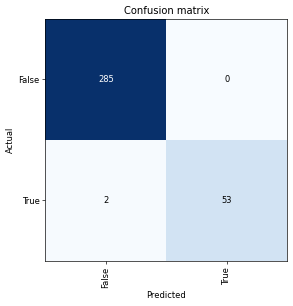

In [73]:
learn.model
preds, targs = learn.get_preds()
acc = accuracy(preds, targs)
print('The validation accuracy is {} %.'.format(acc * 100))


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize= (5,5),dpi=60)


In [17]:
learn.show_results()

# Test predict method on a row

Values can be checked on **hypertension.csv**

How to select a row from file:    
` dataframe row number  = .csv file row + 2 `

- If csv file line is 2 to select this row do:    
    `iatros_df_iloc[0]`
        
- ` iatros_df.iloc[20] ` will be in line 22 of .csv file

In [35]:
row, clas, probs = learn.predict(iatros_df.iloc[20])
row.show()
print('Class: {} \nProbabilities: {}'.format(clas,probs))

In [108]:
# LOAD MODEL
model_path = models_path / 'models'
print(model_path)
path = load_learner(model_path/'hypertension_model.pth', cpu=False)

model = load_model(model_path/'hypertension_model.pth', tabu)

d:\Documents\Development\iAtros\iAtros_challenge\models


In [34]:
#This pagination link can't be converted and breaks the pagination. 

broken_url = 'http://hapi.fhir.org/baseR4?_getpages=300bdb01-0cdf-4349-9299-8304f540cc7c&_getpagesoffset=2320&_count=20&_pretty=true&_bundletype=searchset'
url_params = get_url_params(broken_url)

if len(url_params) > 1:
                #Query for next page
                response = requests.get(broken_url, params=url_params)
                #print(response.text)
               # print(json.dumps(response.json(), indent=2))
                
                if response.status_code == 200:
                    #Initialize a bundle object from request response as json
                    try: 
                        bundle = b.Bundle(response.json())
                    except Exception as e:
                        print('An error ocurred while creating Bundle object')
                        print(e)
                        
                